In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import math
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier

## Part 1: Preprocessing  


Drop columns "Name", "City", "Zip", "Bank", "BankState", "ApprovalDate", "DisbursementDate" as these columns are non-numerical.  

Column "BalanceGross" also need to be dropped as the whole column is $0.00.

In [2]:
df = pd.read_csv('Xtrain.csv')
df_y = pd.read_csv('Ytrain.csv')
df = pd.concat([df, df_y['ChargeOff']], axis=1, sort=False)
df = df.drop(['Id', 'Name', 'City', 'Zip', 'ApprovalDate', 'DisbursementDate', 'BalanceGross'], axis= 1)

### Handling Non-numeric Fields  

Noted that the following columns are not numeric, hence need to convert them into numeric format:  

* **State, Bank and BankState** columns: Extract all the unique values in the column and use its index as the new value  
* **Same_Bank_States** column: Compare whether the bank is in the same state as the company
* **NAICS** column: Based on the information here *https://www.naics.com/search/*, convert the NAICS code to the corresponding industries (code // 10000).

In [3]:
states = {v: k for k, v in enumerate(list(df['State'].unique()))}
df['State'].replace(states, inplace=True)

banks = {v: k for k, v in enumerate(list(df['Bank'].unique()))}
df['Bank'].replace(banks, inplace=True)

bank_states = {v: k for k, v in enumerate(list(df['BankState'].unique()))}
df['BankState'].replace(bank_states, inplace=True)

df["Same_Bank_States"] = df["State"] == df["BankState"]

df["NAICS"] = df["NAICS"].apply(lambda x: x // 10000)

Noted that ther following columns contains non-numeric values, need to reformat the data:

* **DisbursementGross, BalanceGross, GrAppv, SBA_Appv**: remove the dollar sign in each record
* **ApprovalFY**: replace the "1976A" in the column with "1976"
* **RevLineCr, LowDoc**: Convert the format from text (N/Y) to boolean, also replace some invalid values.

In [4]:
df['ApprovalFY'] = df['ApprovalFY'].replace('1976A', 1976)
df['ApprovalFY'] = df['ApprovalFY'].astype(int)

money_cols = ['DisbursementGross', 'GrAppv', 'SBA_Appv']
df[money_cols] = df[money_cols].replace('[\$,]', '', regex=True).astype(float) 

df['LowDoc'] = np.where((df['LowDoc'] == "N") | (df['LowDoc'] == "Y"), df['LowDoc'], np.nan)
df['LowDoc'] = df['LowDoc'].replace({'N': 0, 'Y': 1})

df['RevLineCr'] = np.where((df['RevLineCr'] == "N") | (df['RevLineCr'] == "Y"), df['RevLineCr'], np.nan)
df['RevLineCr'] = df['RevLineCr'].replace({'N': 0, 'Y': 1})

df['LowDoc'].fillna(0, inplace=True)
df['NewExist'].fillna(0, inplace=True)
df['RevLineCr'].fillna(0, inplace=True)
df['LowDoc'] = df['LowDoc'].astype(int)
df['NewExist'] = df['NewExist'].astype(int)
df['RevLineCr'] = df['RevLineCr'].astype(int)

### Exploratory Data Analysis  

**ApprovalFY Column**  

From the plot below, it was noted that there are some clear separation based on the comparision of approved and rejected loans:  

* from 1969 ~ 1988, most of the loan application have been approved
* from 1989 ~ 2003, there's a sudden change and most of the loan were rejected
* from 2004 ~ 2009, again more load application were approved
* after year 2010 (inclusive), the number of rejected loans is more than approved loans again.  

Hence, can try to split these valus into four categories:

* 0: 1969 ~ 1988
* 1: 1989 ~ 2003 
* 2: 2004 ~ 2009
* 3: 2010 ~ 2014 

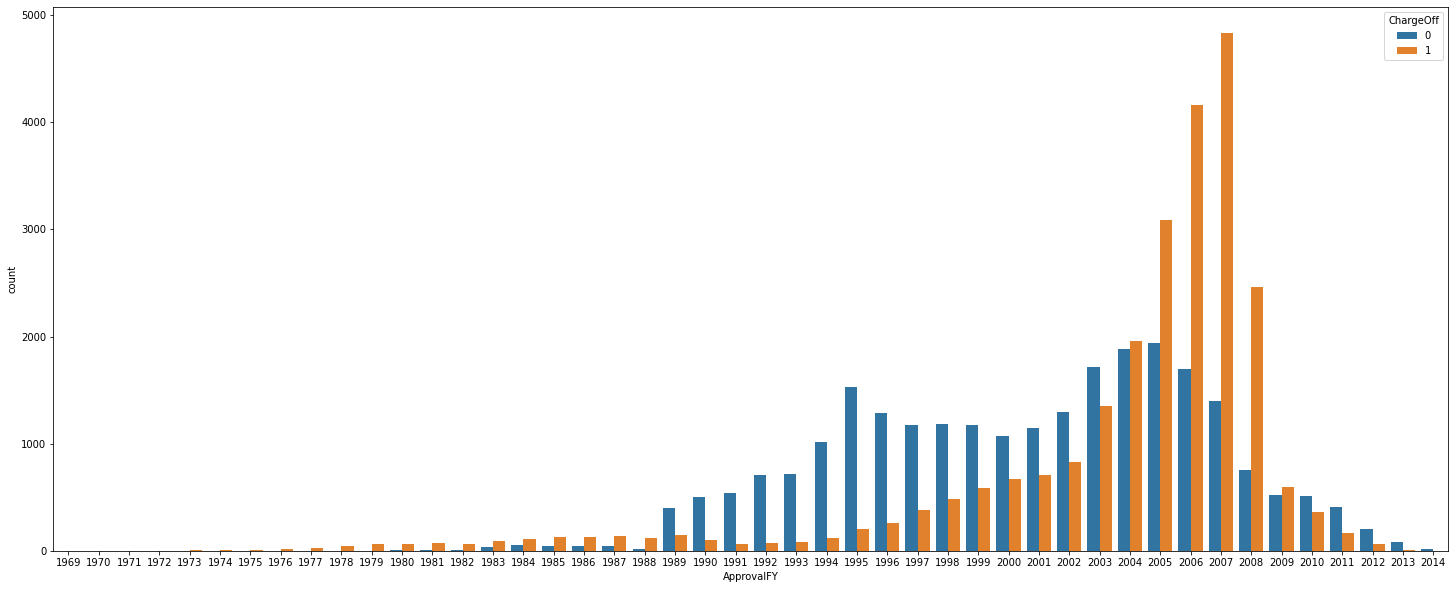

In [5]:
plt.subplots(figsize=(25,10))
sb.countplot(x="ApprovalFY", data = df, hue = 'ChargeOff')
plt.show()

def categorize_year(year):
    if year <= 1988:
        return 0
    elif year >= 1989 and year <= 2003:
        return 1
    elif year >= 2004 and year <= 2009:
        return 2
    else:
        return 3

df["ApprovalFY_Cat"] = df["ApprovalFY"].apply(categorize_year) 

**NoEmp Column**  

From the plot below, we can tell that the distribution of the number of employee is heavily headed and for small businesses, it is more likely that the loan is approved. Hence the NoEmp column can be categorized into the following categories:    

* 0 (small): 0 ~ 10
* 1 (medium): 10 ~ 100 
* 2 (large): more than 100

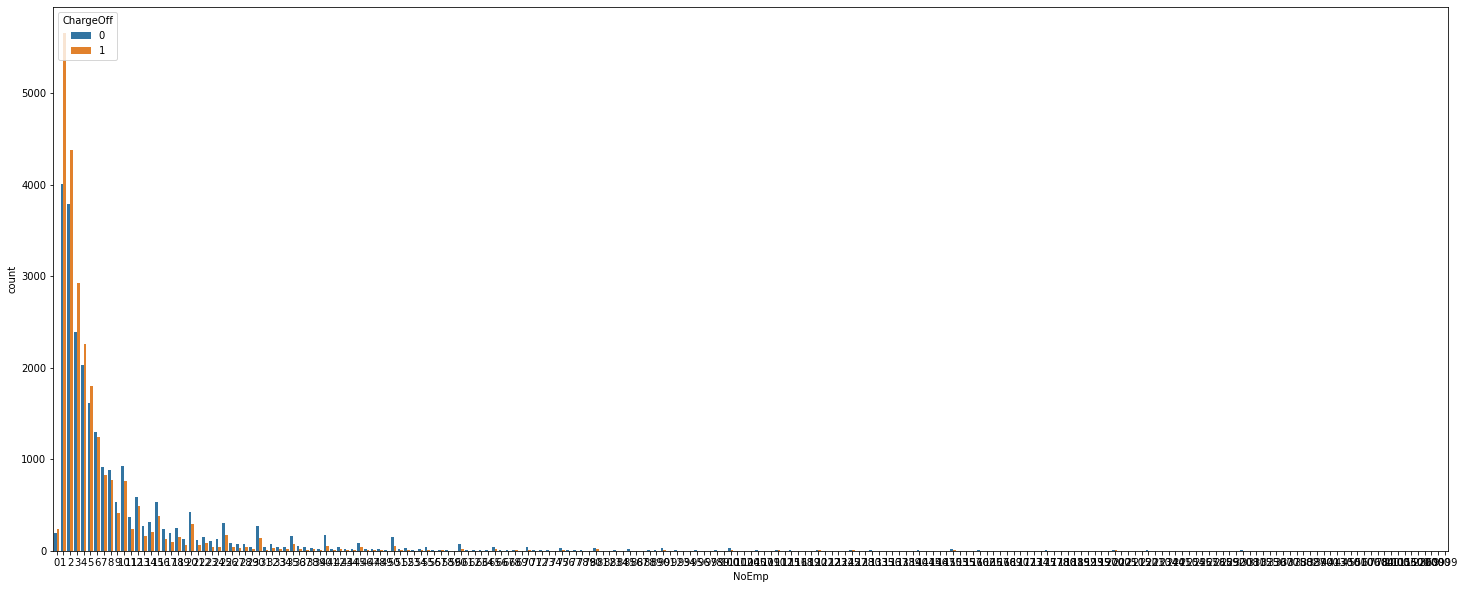

In [6]:
plt.subplots(figsize=(25,10))
sb.countplot(x="NoEmp", data = df, hue = 'ChargeOff')
plt.show()
def categorize_no_emp(number):
    if number <= 10:
        return 0
    elif number > 10 and number <= 100:
        return 1
    else:
        return 2
df["NoEmp_Cat"] = df["NoEmp"].apply(categorize_no_emp) 

**CreateJob Column**  

From the plot below, it was noted that the majority value of the CreateJob column is 0, hence can simply categorize the collumn based on whether the company has created any job:    

* 0 (No Job Created): 0
* 1 (Jobs Created): more than 0

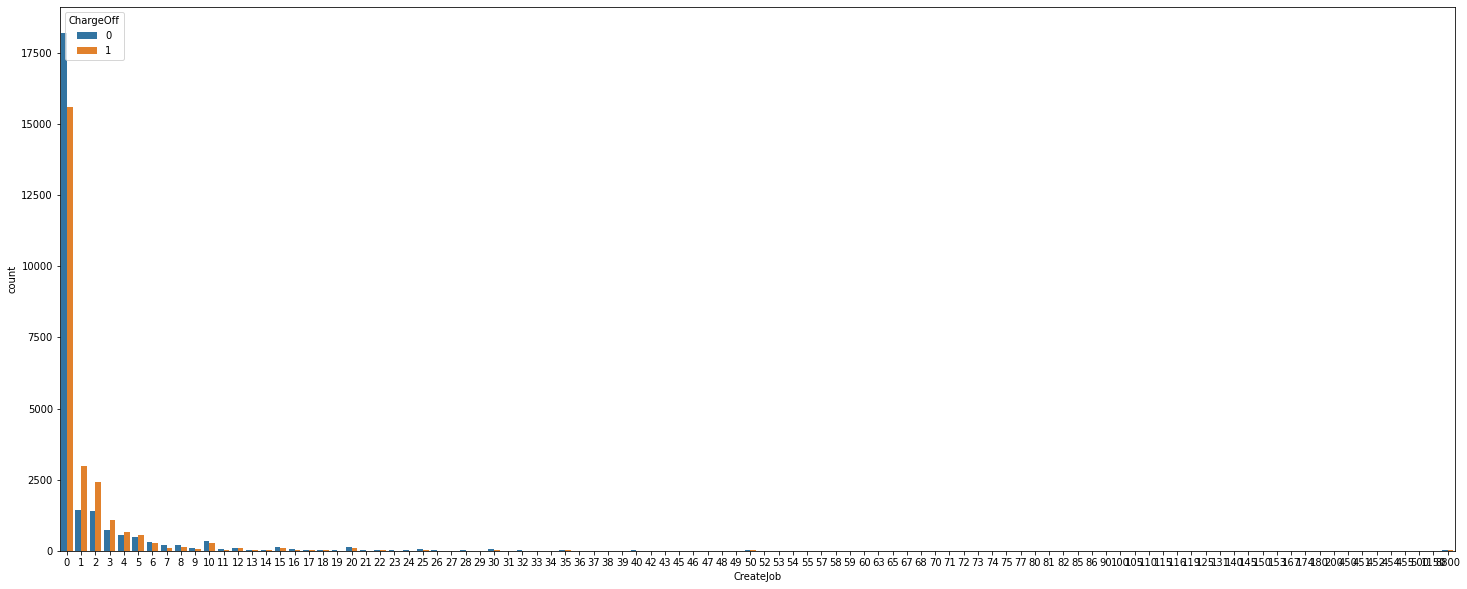

In [7]:
plt.subplots(figsize=(25,10))
sb.countplot(x="CreateJob", data = df, hue = 'ChargeOff')
plt.show()

df["CreateJob_Cat"] = df["CreateJob"].apply(lambda x: x != 0)

**RetainedJob Column**  

From the plot below, we noted the similar pattern as CreateJob, hence we can use the same approach to split the RetainedJob column in to two categories.

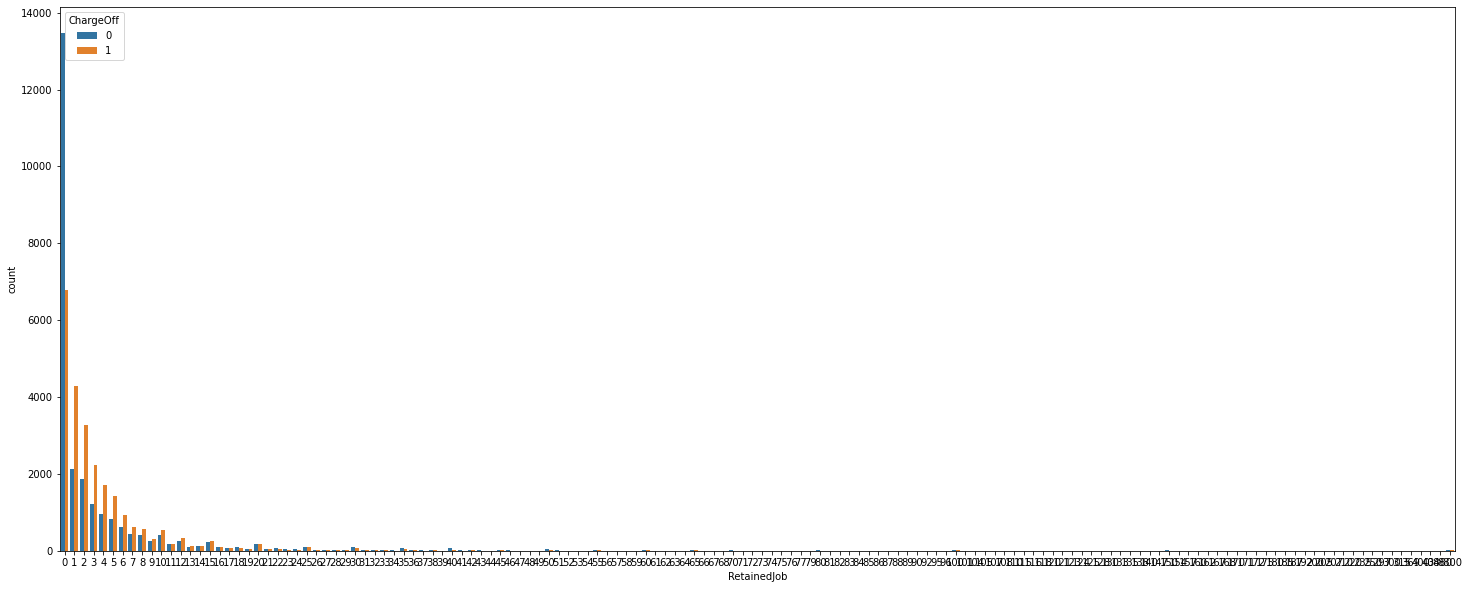

In [8]:
plt.subplots(figsize=(25,10))
sb.countplot(x="RetainedJob", data = df, hue = 'ChargeOff')
plt.show()

df["RetainedJob_Cat"] = df["RetainedJob"].apply(lambda x: x != 0)

**FranchiseCode Column**  

From the information printed below, we noted the similar pattern as CreateJob, hence we can use the same approach to split the FranchiseCode column in to two categories.

In [9]:
print(df.groupby(["FranchiseCode"])["FranchiseCode"].count())

df["FranchiseCode_Cat"] = df["FranchiseCode"].apply(lambda x: x != 0)
print(df["FranchiseCode_Cat"].unique())

FranchiseCode
0        15834
1        31441
3            2
395          1
407          3
         ...  
91280        2
91283        1
91297        1
91350        4
91999        1
Name: FranchiseCode, Length: 849, dtype: int64
[False  True]


**DisbursementGross Column**  

Categorization on the disbursement

In [10]:
def categorize_disbursement(number):
    if number <= 100000:
        return 0
    elif number > 100000 and number <= 500000:
        return 1
    else:
        return 2
df["DisbursementGross_Cat"] = df["DisbursementGross"].apply(categorize_disbursement) 

**SBA_Appv and GrAppv Columns**  

It was noted that both columns is related to the amount granted to the company, The SBA guaranteed amount (SBA_Appv) is a part of the Gross amount (GrAppv), hence we can calculate the relationship between them.

In [11]:
df['SBA_vs_Gross'] = df['SBA_Appv']/df['GrAppv']
sba_vs_gross = df.groupby(["SBA_vs_Gross"])["SBA_vs_Gross"].count().sort_values(ascending=False)
print(sba_vs_gross[sba_vs_gross > 100])

SBA_vs_Gross
0.50    21717
0.75     8930
0.85     7719
0.90     3792
0.80     3482
1.00     2430
0.70      299
Name: SBA_vs_Gross, dtype: int64


## Part 2: Feature Selection

### Correlation between the parameters in the dataset

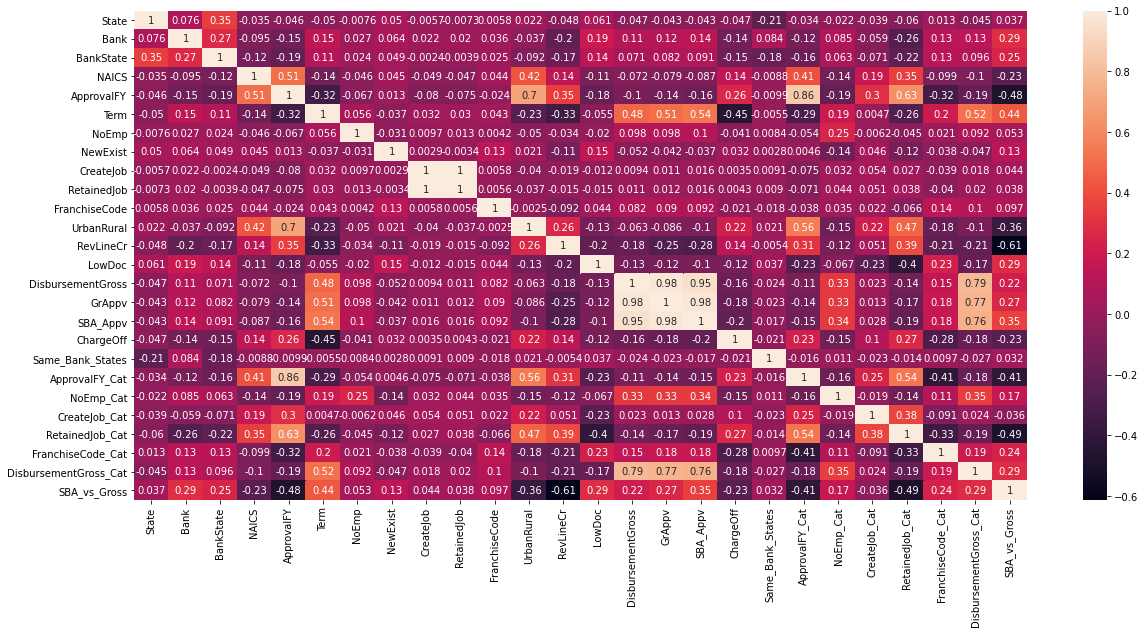

In [12]:
plt.subplots(figsize = (20,9))
sb.heatmap(df.corr(), annot=True)
plt.show()

## Compare the feature importance for using categorized data and continuous data

In [14]:
y = df["ChargeOff"]
x = df.drop(['ChargeOff', 'GrAppv', 'SBA_Appv', 'FranchiseCode_Cat', 'RetainedJob_Cat', 'CreateJob_Cat', 'NoEmp_Cat', 'ApprovalFY_Cat', 'DisbursementGross_Cat'], axis= 1)
x_cat = df.drop(['ChargeOff', 'GrAppv', 'SBA_Appv', 'FranchiseCode', 'RetainedJob', 'CreateJob', 'NoEmp', 'ApprovalFY', 'DisbursementGross'], axis= 1)
model = XGBClassifier()

model.fit(x,y)
importance = pd.Series(model.feature_importances_, index = x.columns).to_dict()
model.fit(x_cat,y)
importance_cat = pd.Series(model.feature_importances_, index = x_cat.columns).to_dict()

print("Feature Importances:\n")
print("ApprovalFY: {}\tApprovalFY_Cat: {}".format(round(importance["ApprovalFY"], 3), round(importance_cat["ApprovalFY_Cat"], 3)))
print("FranchiseCode: {}\tFranchiseCode_Cat: {}".format(round(importance["FranchiseCode"], 3), round(importance_cat["FranchiseCode_Cat"], 3)))
print("RetainedJob: {}\tRetainedJob_Cat: {}".format(round(importance["RetainedJob"], 3), round(importance_cat["RetainedJob_Cat"], 3)))
print("CreateJob: {}\tCreateJob_Cat: {}".format(round(importance["CreateJob"], 3), round(importance_cat["CreateJob_Cat"], 3)))
print("NoEmp: {}\t\tNoEmp_Cat: {}".format(round(importance["NoEmp"], 3), round(importance_cat["NoEmp_Cat"], 3)))
print("Disbursement: {}\tDisbursement_Cat: {}".format(round(importance["DisbursementGross"], 3), round(importance_cat["DisbursementGross_Cat"], 3)))

Feature Importances:

ApprovalFY: 0.173	ApprovalFY_Cat: 0.263
FranchiseCode: 0.032	FranchiseCode_Cat: 0.053
RetainedJob: 0.013	RetainedJob_Cat: 0.025
CreateJob: 0.013	CreateJob_Cat: 0.014
NoEmp: 0.017		NoEmp_Cat: 0.022
Disbursement: 0.026	Disbursement_Cat: 0.026


## Test Continuous Data

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)
model.fit(x_train, y_train)
predict = model.predict(x_test)
print(classification_report(y_test, predict, digits=3))

k_fold = KFold(n_splits=10)
results = cross_val_score(model, x, y, cv=k_fold, scoring="roc_auc")
print("CV Score: {}".format((round(results.mean(), 3))))

              precision    recall  f1-score   support

           0      0.933     0.933     0.933      6342
           1      0.931     0.931     0.931      6158

    accuracy                          0.932     12500
   macro avg      0.932     0.932     0.932     12500
weighted avg      0.932     0.932     0.932     12500

CV Score: 0.98


## Test Categorized Data

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_cat, y, test_size = 0.25, random_state=0)
model.fit(x_train, y_train)
predict = model.predict(x_test)
print(classification_report(y_test, predict, digits=3))

k_fold = KFold(n_splits=10)
results = cross_val_score(model, x_cat, y, cv=k_fold, scoring="roc_auc")
print("CV Score: {}".format((round(results.mean(), 3))))

              precision    recall  f1-score   support

           0      0.929     0.930     0.930      6342
           1      0.928     0.927     0.927      6158

    accuracy                          0.928     12500
   macro avg      0.928     0.928     0.928     12500
weighted avg      0.928     0.928     0.928     12500

CV Score: 0.979
